# 2.5 Active filters

## 2.5.1 Input bias

The definition of bias has a clear reference to electronic systems in definition 3  
![image1!](./images_s2/image_2_5_1.png)  
  
However, the practice can apply equally well to all analogous linear systems  
We will show you the effect of bias on a graviational flow system, because of the intuitive nature of that system  
After that we will apply our results to electronic filters  

Consider a water pump filling a 5 gallon pail  
as shown in the picture below along with the electronic analog  
  
![image2!](./images_s2/image_2_5_2.png)  

Imagine that you turn the pump on and off at a specific frequency  
The flow would look like a square wave as a function of time  
Assume the pump can pump 50 grams of water per second  
  
![image3!](./images_s2/image_2_5_3.png)  
  
It's pretty easy to realize that the flow cannot be negative  
The pump cannot pump backwards.  This is very different than the electrical current source  
  
Let's also assume the pump controller is a little more fancy than on and off  
Assume it can control the flow so it follows a sin wave  
  
The code cell below plots the sin wave flow associated with the pump and compares that to the  
current through a current source

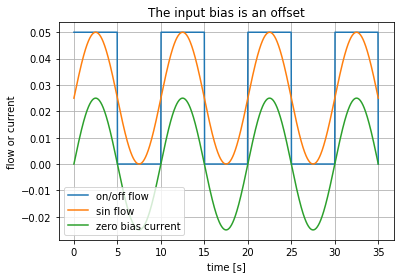

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# assume the pump is turned on and off every 10 seconds
# 5 seconds on, 5 seconds off
T = 10 # period is 10 seconds
f = 1/T # frequency in Hz (cycles per second)
w = 2*np.pi*f # radial frequency in [rad/s]
s = 1j*w

# flow parameters
f_pk_pk = 0.05 # the pump has a maximum flow of 0.05 [kg/s] and a minimum of 0
f_mag = f_pk_pk/2 # the magnitude or amplitude is half of the peak to peak value 
f_ph =-1j*f_mag # flow phasor, sin points down on the complex plane

# create a time array
t = np.linspace(0, 35.0, 1000)

# plot the square wave flow
plt.plot(t, f_mag*sig.square(w*t)+f_mag)

# plot the sin wave flow
plt.plot(t, (f_ph/2*np.exp(s*t)+np.conjugate(f_ph/2)*np.exp(-s*t)).real+f_mag)

# plot the unbiased current through the electrical current source
plt.plot(t, (f_ph/2*np.exp(s*t)+np.conjugate(f_ph/2)*np.exp(-s*t)).real)

plt.legend(['on/off flow', 'sin flow', 'zero bias current'], loc='lower left')
plt.xlabel('time [s]')
plt.ylabel('flow or current')
plt.title('The input bias is an offset')
plt.grid()

You can see that the flow through the water pump is offset above 0  
If you find the average of the flow versus time, the value is 0.025 [kg/s]  
whereas the averge value of the current through the current source is 0.
  
An offset of the input signal, which is different than 0, is known as the input bias. 

## 2.5.2 The response of a system driven by a signal with input bias

In linear systems, an individual sin source cannot have an offset  
This means, the bias must be a separate DC source that turns on at $t=0$ (a step source)  
  
![image4!](./images_s2/image_2_5_4.png)  
  
We can solve for the height of water in the pail, using an lti object.
The transfer function for the pail is the same as a capacitor
  
$$f=C\frac{g\Delta H}{dt}\Rightarrow f=Csg\Delta H\Rightarrow H(s)\equiv\frac{g\Delta H}{f}=\frac{1}{sC}$$  
to calculate the changes in height, we would multiply the transfer function by the inputs  
  
$$g\Delta H=H(s)*f(s)=\left[\frac{1}{sC}\right]\cdot\left[\frac{\frac{A}{2}}{s-j\omega}+\frac{\frac{A^*}{2}}{s+j\omega}+\frac{bias}{s}\right]$$  
For a sinusiodal input of sine wave, we get  
  
$$g\Delta H=\frac{\frac{bias}{C}s^2+\frac{|A|\omega}{C}s+\frac{bias\cdot\omega^2}{C}}{s^4+\omega^2s^2}$$  
The code cell below plots the pail filling as a function of time

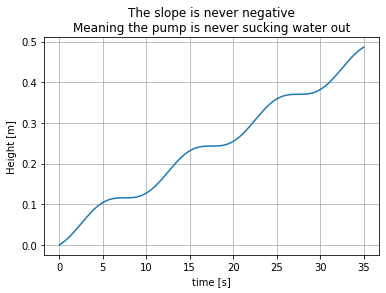

In [2]:
A = 0.025 # amplitude of the sinusiodal flow "on off" variations of the pump [kg/s]
bias = 0.025 # bias flow of the pump [kg/s]
g = 9.81 # m/s^2
rho = 1000 # kg/m^3
C = np.pi*0.025**2*rho/g # tank capacity is base area of pail * density of water / gravitaional constant

num = [bias/(g*C), A*w/(g*C), bias*w**2/(g*C)] # divide by g to get delta H
den = [1, 0, w**2, 0, 0] # don't forget the zeros

dH_s = sig.lti(num, den)
t, dH_t = dH_s.impulse(T=t)

plt.plot(t, dH_t)
plt.xlabel('time [s]')
plt.ylabel('Height [m]')
plt.title('The slope is never negative\nMeaning the pump is never sucking water out')
plt.grid()

## 2.5.3 What if the the pail has a leak

If the pail has a leak, the system becomes  
  
![image5!](./images_s2/image_2_5_5.png)  
and the transfer function times the input sources is  
  
$$g\Delta H=H(s)\times f(s)=\left[\frac{\frac{1}{C}}{s+\frac{1}{RC}}\right]\cdot\left[\frac{\frac{A}{2}}{s-j\omega}+\frac{\frac{A^*}{2}}{s+j\omega}+\frac{bias}{s}\right]$$  
which is almost the same as above, except the denominator changes  
  
$$g\Delta H=\frac{\frac{bias}{C}s^2+\frac{|A|\omega}{C}s+\frac{bias\cdot\omega^2}{C}}{s^4+\frac{1}{RC}s^3+\omega^2s^2+\frac{\omega^2}{RC}s}$$  
The code cell below shows a leaking pail  

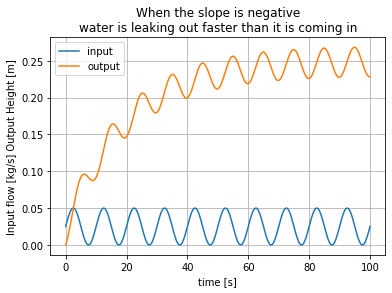

In [3]:
A = 0.025 # amplitude of the sinusiodal flow "on off" variations of the pump [kg/s]
bias = 0.025 # bias flow of the pump [kg/s]
g = 9.81 # m/s^2
rho = 1000 # kg/m^3
R = g*0.5/0.05 # assumes the full pail (0.5m) leaks at the twice the bias rate
C = np.pi*0.025**2*rho/g # tank capacity is base area of pail * density of water / gravitaional constant

# remake the time array, because we need to calculate into the steady state
t = np.linspace(0, 100.0, 1000)

num = [bias/(g*C), A*w/(g*C), bias*w**2/(g*C)] # divide by g to get delta H
den = [1, 1/(R*C), w**2, w**2/(R*C), 0] # don't forget the zero

dH_s = sig.lti(num, den)
t, dH_t = dH_s.impulse(T=t)

# plot the input flow
plt.plot(t, (f_ph/2*np.exp(s*t)+np.conjugate(f_ph/2)*np.exp(-s*t)).real+f_mag)

# plot the output height
plt.plot(t, dH_t)
plt.legend(['input', 'output'], loc='upper left')
plt.xlabel('time [s]')
plt.ylabel('Input flow [kg/s] Output Height [m]')
plt.title('When the slope is negative\nwater is leaking out faster than it is coming in')
plt.grid()

## 2.5.4 The phasor method ignores bias

You can see the height of the liquid in the pail, stablilizes to a steady state AC sin/cos wave above 0  
This means the output height has a bias signal as well  
  
The average of the output height is not zero. It seems to be about 0.25 [m]  
The magnitude of the sin wave variations is just under 1 grid box, peak to peak, or an amplitude of just uner 0.025 [m]  
You can also see a considerable phase shift between the two lines in the graph above, almost $180^\circ$  
  
Although the signals, both input and output have bias components, we can still use the phasor method  
to find the amplitude and the phase shift of the sin/cos changes in height of the water in the pail  
  
But it will ignore the bias voltages, it will just tell us the magnitude of the steady state sin/cos waves  

The phasor method to determine the steady state height variations can be determined from  
  
$$g\Delta H=H(j\omega)\cdot flow\;phasor$$  
or  
  
$$g\Delta H=\left[\frac{\frac{1}{C}}{j\omega+\frac{1}{RC}}\right]\cdot (-j0.025)$$  
the code cell below makes the calulation

In [4]:
dH = (1/(g*C))/(1j*w+1/(R*C))*-1j*0.025
print('delta Height magnitude =', np.abs(dH))
print('delta Height phase =', np.angle(dH, deg=True))

delta Height magnitude = 0.020197992645115622
delta Height phase = -175.36591033043314


## 2.5.5 Microcontrollers (like Arduino) require a biased signal

The high pass filter can be used to add a bias voltage to a signal  
Very often you will see the circuit shown here  
  
![image6!](./images_s2/image_2_5_6.png)  
  
This is a high pass filter that adds a bias to the signal  
The time constant is actually $\frac{RC}{2}$, because the two resistors are in parallel with each other,  
so they combine in parallel, thus the capacitor "sees" half the resistance  
  
When you perform the filter calcultions for the circuit above, you can ignore the bias voltages  
The Bode plot is important, which is calculated using the phasor method  
and we just learned the phasor method ignores the bias components of signals  

## 2.5.6 Active filters

Active filters have a lot of benefits over passive filters,  
including the ability to add bias voltages to signals  

The Operational Amplifier is the key component in active filters  
The figure below shows the general inverting amplifier circuit  
This circuit can be configured to be a high-pass, low-pass, or band-pass filter,
as well as many more useful transfer functions  
Plus, active filters can amplify, increasing the size of small signals  
  
![image7!](./images_s2/image_2_5_7.png)  
  
The transfer function for this circuit is  
  
$$H(s)\equiv\frac{V_{out}}{V_{in}}=-\frac{Z_2(s)}{Z_1(s)}$$

Several of the most common transfer functions are shown in the figure below  
  
![image8!](./images_s2/image_2_5_8.png)  
  
Let's repeat the passive band-pass example we studied previously, now with an active circuit  
We can redesign the components to provide gain  
Use $R_1=1k\Omega$, $C_1=10\mu F$, $R_2=100k\Omega$, and $C_2=1nF$

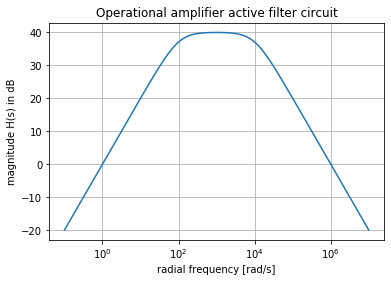

In [5]:
R1 = 1e3 # Ohms
C1 = 10e-6 # Farads
R2 = 1e5 # Ohms
C2 = 1e-9 # Farads

num = [-1/(R1*C2), 0] # don't forget the zero
den = [1, (R1*C1+R2*C2)/(R1*C1*R2*C2), 1/(R1*C1*R2*C2)]
H_s = sig.lti(num, den)

# define  an array of frequencies so we can look at a larger range than the default
w = np.linspace(-1, 7, 1000)
w = 10**w
w, mag, phase = H_s.bode(w=w)
plt.plot(w, mag)
plt.xscale('log')
plt.xlabel('radial frequency [rad/s]')
plt.ylabel('magnitude H(s) in dB')
plt.title('Operational amplifier active filter circuit')
plt.grid()

If you look at the gain in the pass-band, you can see its 40dB  
40dB is a factor of 100, so signals in the pass-band become 100 times bigger at the output as compared to the input  
This circuit can amplify and filter signals at the same time, so small signals can be detected by a microcontroller  

## 2.5.7 Integrators and Differentiators

A circuit that integrates a signal is called an integrator and has an output of the form $V_{out}=\int V_{in}dt$  
If we transfrom this to the frequency domain, we see that $V_{out}(s)=\frac{V_{in}(s)}{s}$  
  
A circuit that differentiates a signal is called a differentiator and has an output of the form $V_{out}=\frac{dV_{in}}{dt}$  
If we transfrom this to the frequency domain, we see that $V_{out}(s)=sV_{in}(s)$  
  
Consider the following circuits and the transfer functions  
  
![image9!](./images_s2/image_2_5_9.png)  
  
In the code cell that follows we will create the Bode plot for each circuit  
Assume $R_1=R_2=10k\Omega$ and $C_1=C_2=1\mu F$

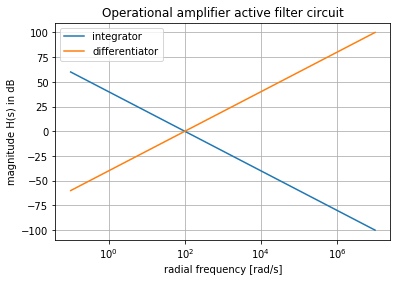

In [6]:
R1 = 1e4 # Ohms
C1 = 1e-6 # Farads
R2 = 1e4 # Ohms
C2 = 1e-6 # Farads

num = [-1]
den = [R1*C2, 0] # don't forget the zero
H_s_int = sig.lti(num, den)

num = [-R2*C1, 0] # don't forget the zero
den = [1]
H_s_diff = sig.lti(num, den)

# define  an array of frequencies so we can look at a larger range than the default
w = np.linspace(-1, 7, 1000)
w = 10**w
w, mag, phase = H_s_int.bode(w=w)
plt.plot(w, mag)
w, mag, phase = H_s_diff.bode(w=w)
plt.plot(w, mag)
plt.legend(['integrator', 'differentiator'])
plt.xscale('log')
plt.xlabel('radial frequency [rad/s]')
plt.ylabel('magnitude H(s) in dB')
plt.title('Operational amplifier active filter circuit')
plt.grid()

In the frequency domain,  
Integration means reducing the signal in inverse proportion to the frequency of that signal  
  
While differentiation is the opposite  
Differentiation means increasing the signal proportionally to the frequency of that signal  
  
In reality, these circuits have practical problems  
In both the integrator and differentiator, the gain approaches infinity  
Integrators will drift and saturate, while differentiators will oscillate on their own.  
  
In practice, the low-pass filter is used for the integrator, with a very large value for $R_2$  
In the same manner, a high-pass filter is used for the differentiator, with a very small value for $R_1$  
  
In this case, the low-pass filter is called a "lossy" integrator  
while the high-pass filter is called a "lossy" differentiator  
  
Whenever the Bode plot is dropping at $-20db\;per\;decade$, those frequencies are being integrated  
and likewise, when the Bode plot is rising at $+20db\;per\;decade$, those frequencies are being differentiated  